## [1. Import Needed Modules](#import) ##
## [2. Read in images and create a dataframe of image paths and class labels](#makedf) ## 
## [3. Trim the train_df dataframe](#trim) ##
## [4. Balance the train_df dataframe](#balance) ##
## [5. Create train, test and validation generators](#generators) ## 
## [6. Create a function to show Training Image Samples](#show) ## 
## [7. Create the Model](#model) ## 
## [8. Create a custom Keras callback to continue or halt training](#callback) ## 
## [9. Instantiate custom callback and create callbacks to control learning rate and early stopping](#callbacks) ##
## [10. Train the model](#train) ##
## [11. Define a function to plot the training data](#plot) ##
## [12. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [13. Save the model](#save) ##


<a id="import"></a>
# <center>Import Need Modules</center>

In [2]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model



<a id="makedf"></a>
# <center>Read in images and create a dataframe of image paths and class labels</center>


In [16]:
sdir=r'../input/2000-hand-gestures/images'
classlist=sorted(os.listdir(sdir))
print (classlist)
filepaths = []
labels=[] 
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=sorted(os.listdir(classpath))
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)
train_df, dummy_df=train_test_split(df, train_size=.85, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])     
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

['closed fist', 'finger circle', 'finger symbols', 'multi finger bend', 'open palm', 'semi-open fist', 'semi-open palm', 'single finger bend']
train_df lenght:  1841   test_df length:  163   valid_df length:  163
The number of classes in the dataset is:  8
            CLASS               IMAGE COUNT 
         closed fist                180     
        finger circle               198     
        finger symbols              449     
      multi finger bend             59      
          open palm                 156     
        semi-open fist              307     
        semi-open palm              289     
      single finger bend            203     
finger symbols  has the most images=  449   multi finger bend  has the least images=  59
average height=  206  average width=  156 aspect ratio=  1.3245372446038557


<a id="Trim"></a>
# <center>Trim the datasets</center>
### The train_df is very misbalanced. It also is very large as are the test_df and the valid_df
### use the trim function so that no class in train_df has more than max_samples= 200 images.

In [17]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=200
min_samples=0
column='labels'
train_df=trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  200  and the minimum samples in any class is  0


<a id="balance"></a>
# <center>Balance the dataset</center>
### The balance function defined below takes in a dataframe and an inter n and returns a dataframe
### where each class has n samples in each class. Working_dir is the directory where augment images
### are stored and img_size is the size of the augmented images
### If the augmented images were previously created you are queried as to creating new augmented images
### or use the existing images

In [18]:
def balance(df, n, working_dir, img_size):
    def augment(df,n, working_dir, img_size):
        aug_dir=os.path.join(working_dir, 'aug')
        os.mkdir(aug_dir)        
        for label in df['labels'].unique():    
            dir_path=os.path.join(aug_dir,label)    
            os.mkdir(dir_path)
        # create and store the augmented images  
        total=0
        gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                      height_shift_range=.2, zoom_range=.2)
        groups=df.groupby('labels') # group by class
        for label in df['labels'].unique():  # for every class               
            group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
            sample_count=len(group)   # determine how many samples there are in this class  
            if sample_count< n: # if the class has less than target number of images
                aug_img_count=0
                delta=n - sample_count  # number of augmented images to create
                target_dir=os.path.join(aug_dir, label)  # define where to write the images
                msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
                print(msg, '\r', end='') # prints over on the same line
                aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                                class_mode=None, batch_size=1, shuffle=False, 
                                                save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                                save_format='jpg')
                while aug_img_count<delta:
                    images=next(aug_gen)            
                    aug_img_count += len(images)
                total +=aug_img_count
        print('Total Augmented images created= ', total)
        # create aug_df and merge with train_df to create composite training set ndf
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)        
        df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
        return df 
    
    df=df.copy() 
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')    
    if 'aug' in os.listdir(working_dir):
        print(' Augmented images already exist. To delete these and create new images enter D, else enter U to use these images', flush=True)
        ans=input(' ')
        if ans == 'D' or ans == 'd':            
            shutil.rmtree(aug_dir) # start with an clean empty directory  
            augment(df,n, working_dir, img_size)
            return df
        else:
            
            return df
    else:
        augment(df,n, working_dir, img_size)
        return df
        
   
n=200 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(200,160) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

 Augmented images already exist. To delete these and create new images enter D, else enter U to use these images


  d


Found 180 validated image filenames.     for class          closed fist           creating  20   augmented images 
Found 156 validated image filenames.     for class           open palm            creating  44   augmented images 
Found 198 validated image filenames.     for class         finger circle          creating   2   augmented images 
Found 59 validated image filenames.      for class       multi finger bend        creating  141  augmented images 
Total Augmented images created=  207


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [19]:
batch_size=30 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1393 validated image filenames belonging to 8 classes.           for train generator 
Found 163 validated image filenames belonging to 8 classes.            for valid generator 
Found 163 validated image filenames belonging to 8 classes.            for test generator 
test batch size:  1   test steps:  163  number of classes :  8


<a id="show"></a>
# <center>Create a function to show example training images</center>

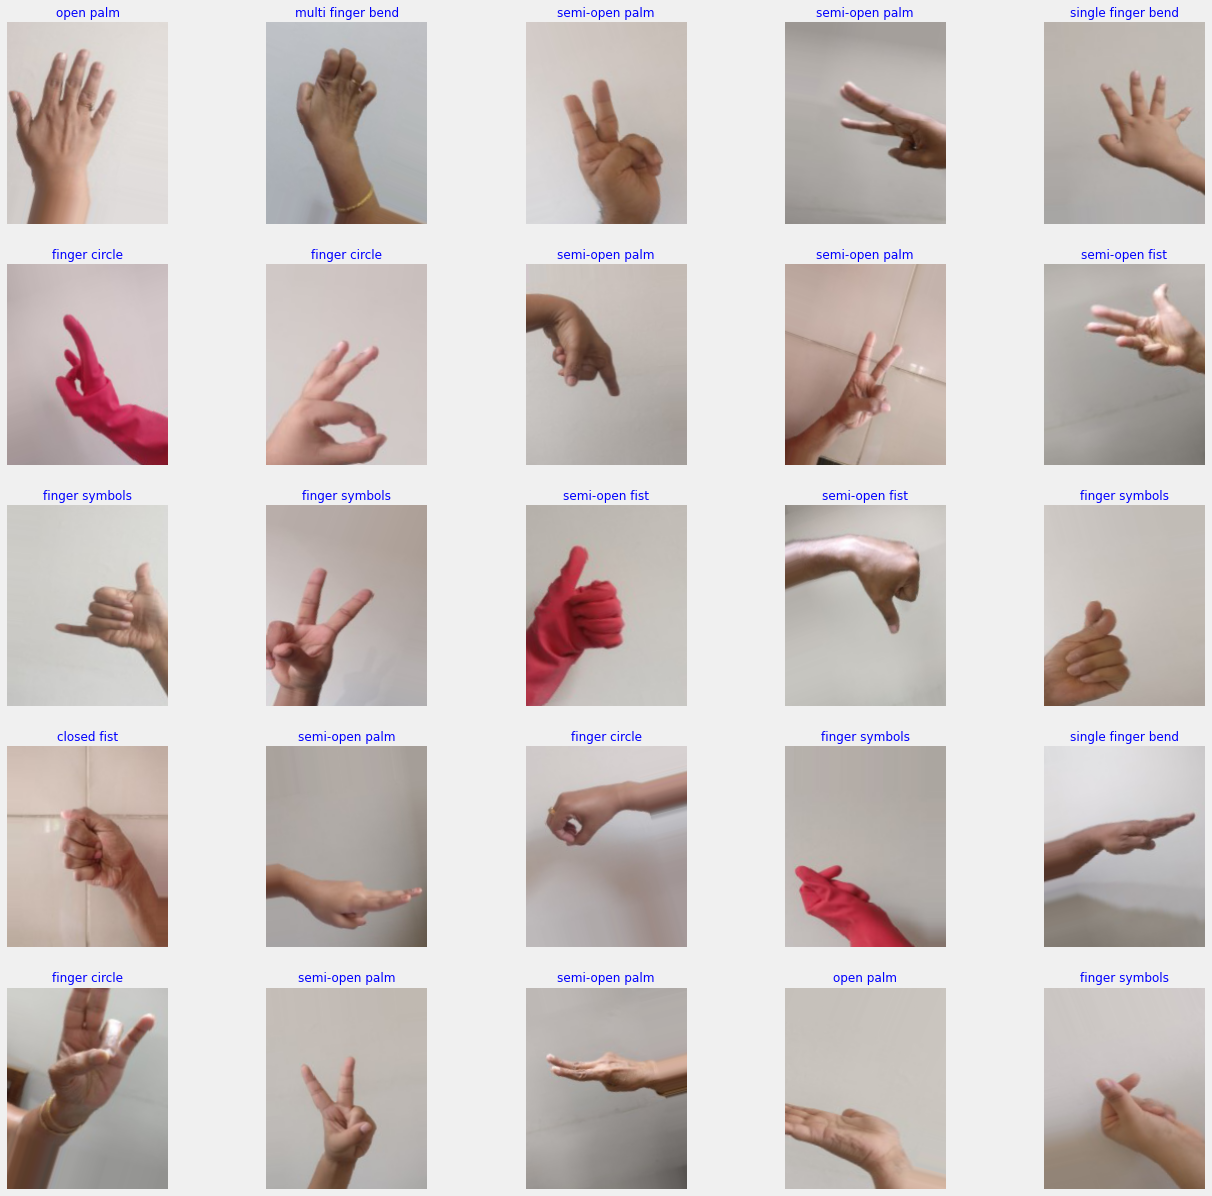

In [20]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB5</center>
### NOTE experts advise you make the base model initially not trainable. Then train for some number of epochs
### then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs!

In [21]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB5'
base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

115277824/115263384 [==============================] - 4s 0us/step


<a id="callback"></a>
# <center>Create a custom Keras callback to continue or halt training</center>

In [22]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

<a id="callbacks"></a>
# <center>Instantiate custom callback and create 2 callbacks to control learning rate and early stop

In [23]:
epochs=40
ask_epoch=10
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset
### It will converge faster and have a lower validation losss

In [24]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
47/47 [==============================] - 54s 618ms/step - loss: 9.9434 - accuracy: 0.3453 - val_loss: 10.4238 - val_accuracy: 0.4294
Epoch 2/40
47/47 [==============================] - 25s 519ms/step - loss: 8.4337 - accuracy: 0.5628 - val_loss: 8.1595 - val_accuracy: 0.6319
Epoch 3/40
47/47 [==============================] - 25s 521ms/step - loss: 7.5315 - accuracy: 0.6454 - val_loss: 7.2154 - val_accuracy: 0.7117
Epoch 4/40
47/47 [==============================] - 24s 508ms/step - loss: 6.6846 - accuracy: 0.7373 - val_loss: 6.5279 - val_accuracy: 0.7669
Epoch 5/40
47/47 [==============================] - 25s 522ms/step - loss: 5.9879 - accuracy: 0.7897 - val_loss: 5.8801 - val_accuracy: 0.7975
Epoch 6/40
47/47 [==============================] - 24s 516ms/step - loss: 5.3693 - accuracy: 0.8205 - val_loss: 5.2570 - 

 8


you entered  8  Training will continue to epoch  18
Epoch 11/40
47/47 [==============================] - 25s 518ms/step - loss: 3.2575 - accuracy: 0.9095 - val_loss: 3.2700 - val_accuracy: 0.8528
Epoch 12/40
47/47 [==============================] - 24s 515ms/step - loss: 2.9175 - accuracy: 0.9325 - val_loss: 2.9649 - val_accuracy: 0.8650
Epoch 13/40
47/47 [==============================] - 24s 510ms/step - loss: 2.6060 - accuracy: 0.9526 - val_loss: 2.7534 - val_accuracy: 0.8282
Epoch 14/40
47/47 [==============================] - 25s 521ms/step - loss: 2.3837 - accuracy: 0.9526 - val_loss: 2.4772 - val_accuracy: 0.8650
Epoch 15/40
47/47 [==============================] - 25s 519ms/step - loss: 2.1449 - accuracy: 0.9627 - val_loss: 2.3219 - val_accuracy: 0.8528
Epoch 16/40
47/47 [==============================] - 24s 517ms/step - loss: 1.9477 - accuracy: 0.9576 - val_loss: 2.0819 - val_accuracy: 0.8650
Epoch 17/40
47/47 [==============================] - 24s 512ms/step - loss: 1.7549 -

 7


you entered  7  Training will continue to epoch  25
Epoch 19/40
47/47 [==============================] - 25s 519ms/step - loss: 1.4323 - accuracy: 0.9648 - val_loss: 1.5402 - val_accuracy: 0.9080
Epoch 20/40
47/47 [==============================] - 25s 518ms/step - loss: 1.3072 - accuracy: 0.9655 - val_loss: 1.4200 - val_accuracy: 0.8773
Epoch 21/40
47/47 [==============================] - 24s 510ms/step - loss: 1.1650 - accuracy: 0.9770 - val_loss: 1.3538 - val_accuracy: 0.8896
Epoch 22/40
47/47 [==============================] - 24s 516ms/step - loss: 1.0798 - accuracy: 0.9691 - val_loss: 1.1998 - val_accuracy: 0.9080
Epoch 23/40
47/47 [==============================] - 25s 517ms/step - loss: 0.9897 - accuracy: 0.9641 - val_loss: 1.1240 - val_accuracy: 0.8773
Epoch 24/40
47/47 [==============================] - 25s 519ms/step - loss: 0.8816 - accuracy: 0.9792 - val_loss: 1.0770 - val_accuracy: 0.8896
Epoch 25/40
47/47 [==============================] - 24s 509ms/step - loss: 0.8288 -

 2


you entered  2  Training will continue to epoch  27
Epoch 26/40
47/47 [==============================] - 24s 508ms/step - loss: 0.7482 - accuracy: 0.9828 - val_loss: 1.0254 - val_accuracy: 0.8712
Epoch 27/40
47/47 [==============================] - 25s 521ms/step - loss: 0.6787 - accuracy: 0.9885 - val_loss: 1.0374 - val_accuracy: 0.8528

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 h


you entered  h  Training halted on epoch  27  due to user input

training elapsed time was 0.0 hours, 11.0 minutes, 57.02 seconds)


<a id="plot"></a>
# <center>Define a function to plot the training data

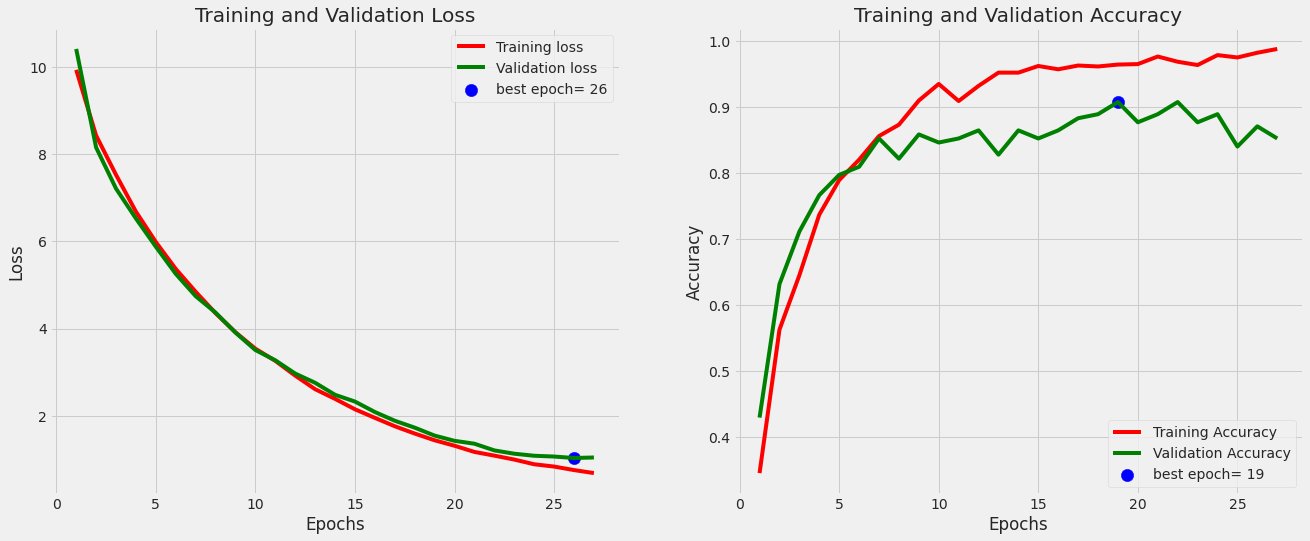

In [25]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

<a id="result"></a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

163/163 [==============================] - 9s 36ms/step
there were 17 in 163 tests for an accuracy of  89.57


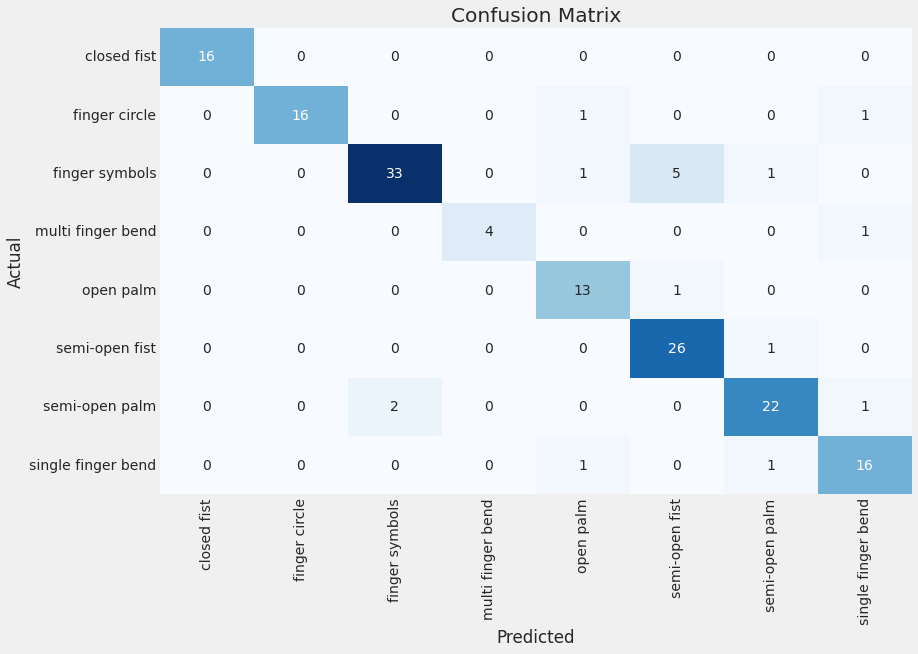

Classification Report:
----------------------
                     precision    recall  f1-score   support

       closed fist     1.0000    1.0000    1.0000        16
     finger circle     1.0000    0.8889    0.9412        18
    finger symbols     0.9429    0.8250    0.8800        40
 multi finger bend     1.0000    0.8000    0.8889         5
         open palm     0.8125    0.9286    0.8667        14
    semi-open fist     0.8125    0.9630    0.8814        27
    semi-open palm     0.8800    0.8800    0.8800        25
single finger bend     0.8421    0.8889    0.8649        18

          accuracy                         0.8957       163
         macro avg     0.9112    0.8968    0.9004       163
      weighted avg     0.9030    0.8957    0.8962       163



In [26]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

<a id="save"></a>
# <center>Save the model

In [27]:
subject='gestures' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 
   

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


model was saved as  ./gestures_89.57.h5
